Notebook purpose

- Determine appropriate model specifications

Background: 

- avg hh savings in uk: https://www.nimblefins.co.uk/savings-accounts/average-household-savings-uk#nogo

In [1]:
import contextlib
import os
import re
import sys

import linearmodels as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.selectors as sl
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

## Load raw data

In [2]:
dfs, df = hd.read_samples(["777", "XX7"])
hd.inspect(df)

Time for read_sample    : 3.70 seconds
Time for read_sample    : 5.71 minutes
(16,074,957, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1088993,2012-04-02,57,23.74,1982 01apr 12 the broadway fruiterer london gb,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-10-23,True,NaN,NaN,NaN,NaN,NaN,u,201204,NaN,22542.600586,2.425209
1,1088994,2012-04-02,57,25.68,1982 01apr 12 waitrose 835 crouch end gb,waitrose,spend,household,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-08-15,True,NaN,waitrose,"food, groceries, household",NaN,supermarket,u,201204,NaN,22542.600586,2.425209


## Make analysis data

Make user-ym panel comprising dependent and independent variables

In [52]:
month = pd.Grouper(key="date", freq="m")
idx_cols = ["user_id", month]

column_makers = []


def column_adder(func):
    column_makers.append(func)
    return func


def trim_columns_upper(df, pct=0, ends="upper"):
    return df.apply(lambda x: hd.trim(x, pct=pct))


@column_adder
def obs_count(df):
    return df.groupby(idx_cols).id.count().rename("obs")


@column_adder
def account_balances(df):
    """Calculates average monthly balances for user's savings and current accounts."""
    return (
        df.loc[df.account_type.isin(["current", "savings"])]
        # daily account balances
        .groupby(
            ["user_id", "account_type", "account_id", "date"],
            observed=True,
        )
        .balance.first()
        # daily account type balances
        .groupby(["user_id", "account_type", "date"], observed=True)
        .sum()
        # monthly account type mean balance
        .reset_index()
        .set_index("date")
        .groupby(["user_id", "account_type"])
        .balance.resample("m")
        .mean()
        # reformat
        .unstack(level="account_type")
        .rename(columns={"current": "balance_ca", "savings": "balance_sa"})
    )


@column_adder
def savings_accounts_flows(df):
    """Calculates monthly inflows, outflows, and net-inflows into user's savings accounts.

    Also calculates scaled flows by dividing by users monthly income.
    """
    df = df.copy()
    df["debit"] = df.debit.replace({True: "sa_outflows", False: "sa_inflows"})
    is_not_interest_txn = ~df.tag_auto.str.contains("interest", na=False)
    is_savings_account = df.account_type.eq("savings")
    mask = is_not_interest_txn & is_savings_account
    group_cols = idx_cols + ["income", "debit"]

    return (
        df[mask]
        .groupby(group_cols)
        .amount.sum()
        .abs()
        .unstack()
        .fillna(0)
        .reset_index("income")
        .assign(
            sa_net_inflows=lambda df: df.sa_inflows - df.sa_outflows,
            sa_scaled_inflows=lambda df: df.sa_inflows / (df.income / 12),
            sa_scaled_outflows=lambda df: df.sa_outflows / (df.income / 12),
            sa_scaled_net_inflows=lambda df: df.sa_net_inflows / (df.income / 12),
        )
        .drop(columns="income")
    )


@column_adder
def entropy(df):
    return df.groupby(idx_cols).entropy_sptac.first()


@column_adder
def total_monthly_spend(df):
    """Calculates total spend per user-month."""
    mask = df.tag_group.eq("spend")
    return df[mask].groupby(idx_cols).amount.sum().rename("total_monthly_spend")


@column_adder
def tag_monthly_spend(df):
    """Calculates spend per tag per user-month."""
    df = df.copy()
    df["tag"] = df.tag.cat.rename_categories(lambda x: "tag_spend_" + x)
    mask = df.tag_group.eq("spend")
    group_cols = idx_cols + ["tag"]
    return df[mask].groupby(group_cols, observed=True).amount.sum().unstack().fillna(0)


def trim_columns(df, col_names, **kwargs):
    """Returns df with trimmed values for selected columns."""
    df = df.copy()
    df[col_names] = df[col_names].apply(hd.trim, **kwargs)
    return df


def main(df):
    data = pd.concat((func(df) for func in column_makers), axis=1)

    colnames_upper = colname_subset(data, "sa_(?:scaled_)?(?:inflows|outflows)")
    colnames_both = colname_subset(data, "balance|sa_scaled|entropy|spend")
    data = trim_columns(data, colnames_upper, how="upper", pct=1)
    data = trim_columns(data, colnames_both, how="both", pct=1)
    return data


filepath = "/Users/fgu/tmp/en/analysis_data_XX7.parquet"
# data = main(df)
# ha.write_parquet(data, filepath, index=True)

data = ha.read_parquet(filepath)
hd.inspect(data)

/Users/fgu/tmp/en/analysis_data_XX7.parquet (of shape (163915, 20)) written.
(163,915, 20)


obs  balance_ca  balance_sa  sa_inflows  sa_outflows  \
user_id date                                                               
57      2012-04-30   66         0.0         NaN         NaN          NaN   
        2012-05-31   75         0.0         NaN         NaN          NaN   

                    sa_net_inflows  sa_scaled_inflows  sa_scaled_outflows  \
user_id date                                                                
57      2012-04-30             NaN                NaN                 NaN   
        2012-05-31             NaN                NaN                 NaN   

                    sa_scaled_net_inflows  entropy_sptac  total_monthly_spend  \
user_id date                                                                    
57      2012-04-30                    NaN       2.425209           883.679993   
        2012-05-31                    NaN       2.363752           931.960022   

                    tag_spend_household  tag_spend_hobbies  tag_spend_retail  \
user_id date                                                                   
57      2012-04-30           354.239990               9.99              8.28   
        2012-05-31           437.809998               9.99              0.00   

                    tag_spend_services  tag_spend_other_spend  \
user_id date                                                    
57      2012-04-30          217.229996              60.000000   
        2012-05-31          296.200012             -13.270006   

                    tag_spend_finance  tag_spend_travel  \
user_id date                                              
57      2012-04-30               0.74        202.299988   
        2012-05-31               1.03        138.250000   

                    tag_spend_communication  tag_spend_motor  
user_id date                                                  
57      2012-04-30                30.900000              0.0  
        2012-05-31                61.949997              0.0

### Validation

In [53]:
validator_funcs = []


def validator(func):
    """Adds func to validator functions."""
    validator_funcs.append(func)
    return func


@validator
def user_date_index(df):
    """Checks that index is user-date."""
    assert df.index.names == ["user_id", "date"]


def validate_data(df):
    for func in validator_funcs:
        func(df)


validate_data(data)

## Sumstats

In [54]:
def sumstats_table(df, cols):
    """Creats basic summary statistics table for colums."""
    order = ["count", "mean", "std", "min", "max", "25%", "50%", "75%"]
    return df[cols].describe().T[order]


def latex_sumstat_table(sumstats_table):
    return tabulate.tabulate(sumstats_table, headers="keys", tablefmt="latex_booktabs")


def write_table(table, path):
    """Writes printed table to path."""
    with open(path, "w+") as f:
        with contextlib.redirect_stdout(f):
            print(table)
    print(f"Table written to {path}.")


pattern = "\w"
cols = colname_subset(data, pattern)
sumstats = sumstats_table(data, cols)
latex_sumstats = latex_sumstat_table(sumstats)
fp = os.path.join(config.TABDIR, "sumstats.tex")
write_table(latex_sumstats, fp)
sumstats

Table written to /Users/fgu/dev/projects/entropy/output/tables/sumstats.tex.


,count,mean,std,min,max,25%,50%,75%
obs,163915.0,98.068859,51.257414,11.000000,656.000000,63.000000,89.000000,123.000000
balance_ca,159116.0,1130.199463,4834.210938,-12257.117188,34628.589844,-884.007996,81.886841,1395.455078
balance_sa,64935.0,2625.156006,5496.725586,-1644.621460,42168.609375,2.210007,457.499939,2500.000000
sa_inflows,60583.0,780.843750,1507.547729,0.000000,13800.000000,60.000000,251.000000,790.385010
sa_outflows,60583.0,749.975220,1452.101318,0.000000,12075.480469,0.000000,200.000000,800.000000
sa_net_inflows,61195.0,75.746101,3330.151123,-69750.000000,120000.000000,-180.000000,17.700001,256.000000
sa_scaled_inflows,59977.0,0.335841,0.548266,0.000000,4.137818,0.031901,0.134704,0.383184
sa_scaled_outflows,59977.0,0.332819,0.576240,0.000000,4.039455,0.000000,0.105145,0.392159
sa_scaled_net_inflows,59971.0,0.007137,0.614697,-4.034811,4.184336,-0.084530,0.008627,0.133873
entropy_sptac,160635.0,2.569474,0.215097,1.902120,2.999520,2.432392,2.589158,2.727904


## Bivariate plots

regplots

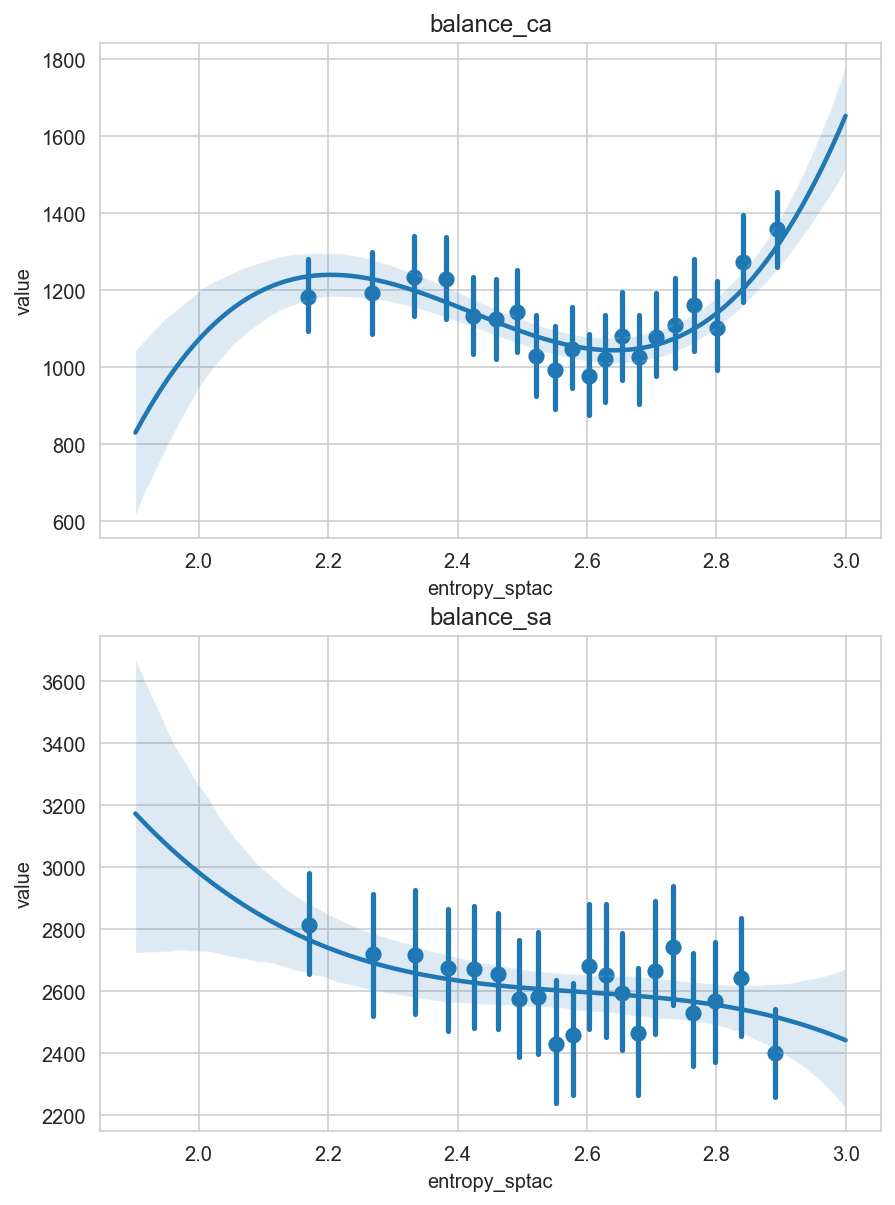

In [110]:
def make_data(df, col_name, **trim_kws):
    return (
        df.set_index("entropy_sptac", append=True)
        .loc[:, col_name]
        .rename("value")
        .reset_index("entropy_sptac")
    )


def make_plot(df, axis):
    sns.regplot(
        data=df, y="value", x="entropy_sptac", order=3, x_bins=20, ci=95, ax=ax[axis]
    )


pattern = "balance_"
outcome_vars = colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(num_vars, 1, figsize=(7, 5 * num_vars))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var)
    make_plot(d, idx)
    ax[idx].set_title(var)

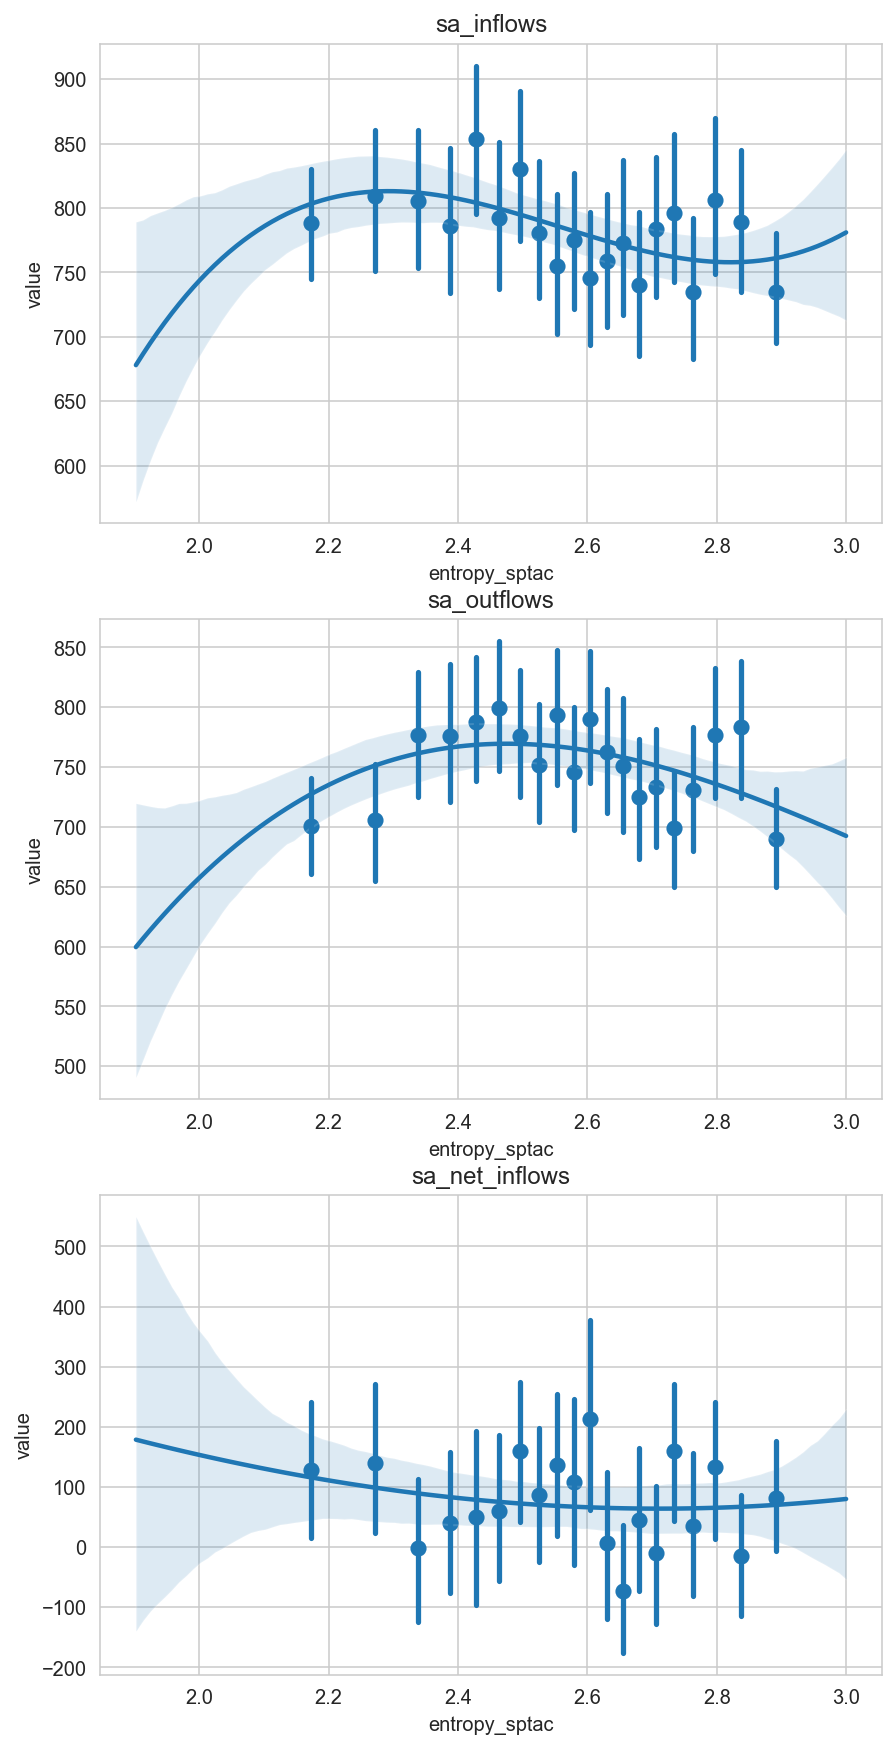

In [111]:
pattern = "sa_[oin]"
outcome_vars = colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(num_vars, 1, figsize=(7, 5 * num_vars))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var)
    make_plot(d, idx)
    ax[idx].set_title(var)

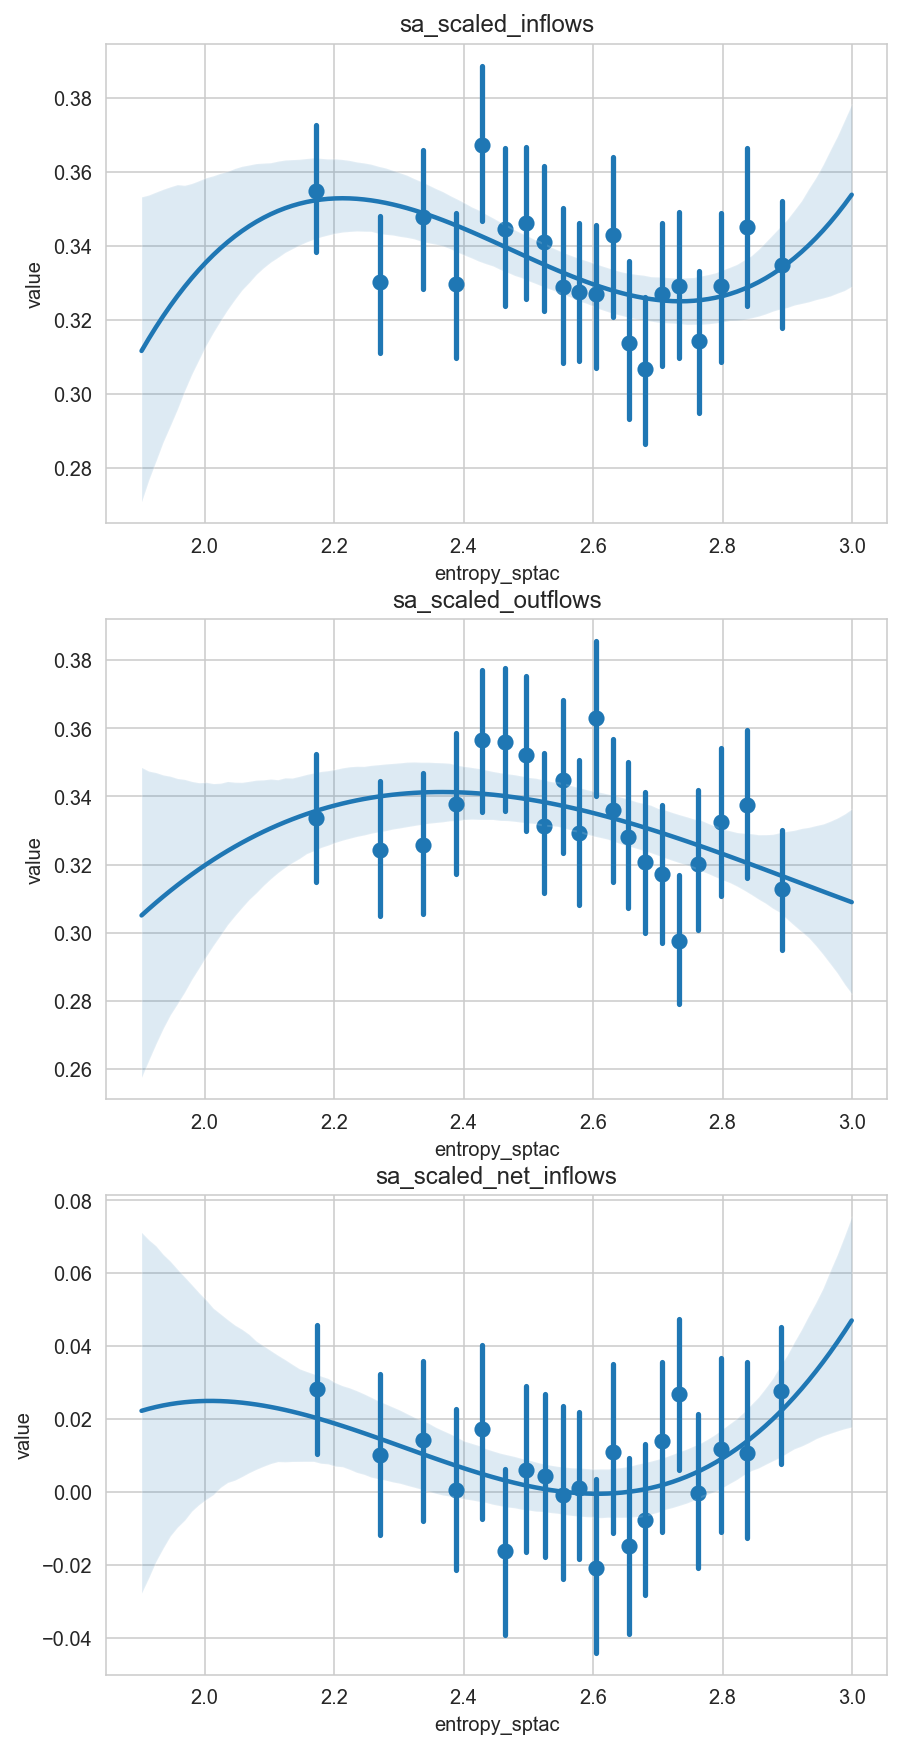

In [112]:
pattern = "sa_scaled"
outcome_vars = colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(num_vars, 1, figsize=(7, 5 * num_vars))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var)
    make_plot(d, idx)
    ax[idx].set_title(var)

## Main results

Full FE equation as baseline

## Lagged-dependent variable